In [98]:
%matplotlib widget

import sys
import os
import logging
import matplotlib
import mplcursors
import matplotlib.pyplot as plt 
import numpy as np
from astropy.io.votable import parse
from astropy.visualization import astropy_mpl_style
from astropy.coordinates import SkyCoord
from astropy.time import Time
import astropy.units as u

from pyvo.dal.scs import SCSService

from pyvo.mivot.viewer.mivot_viewer import MivotViewer
from pyvo.mivot.features.sky_coord_builder import SkyCoordBuilder
from pyvo.mivot.utils.dict_utils import DictUtils
from pyvo.mivot.utils.xml_utils import XmlUtils

from pyvo.utils import activate_features
from pyvo.dal.scs import SCSService

activate_features("MIVOT")


In [114]:

def add_tooltips(scatter, texts):
    cursor = mplcursors.cursor(scatter, hover=True)

    @cursor.connect("add")
    def on_add(sel):
        sel.annotation.set_text(texts[sel.index])
        sel.annotation.get_bbox_patch().set(fc="yellow", alpha=1)  # style optionnel
        sel.annotation.set_ha("left") 
        
def build_scatter(subplot, ra, decs, text, color):
    subplot.ticklabel_format(useOffset=False)
    scatter =  subplot.scatter(ras, decs, color=color)
    for i, txt in enumerate(text):
        subplot.annotate(txt[:6], (ras[i], decs[i]))
    return scatter
    
def setup_plot():
    _, ax = plt.subplots()
    plt.title(f"Simbed CS on {RA} {DEC} R={SR}")
    plt.xlabel("RA")
    plt.ylabel("DEC")
    return ax



In [115]:

SERVER = "https://simbad.cds.unistra.fr/cone?"
VERB = 1
RA = 269.452076* u.degree
DEC = 4.6933649* u.degree
SR = 0.1* u.degree
MAXREC = 100


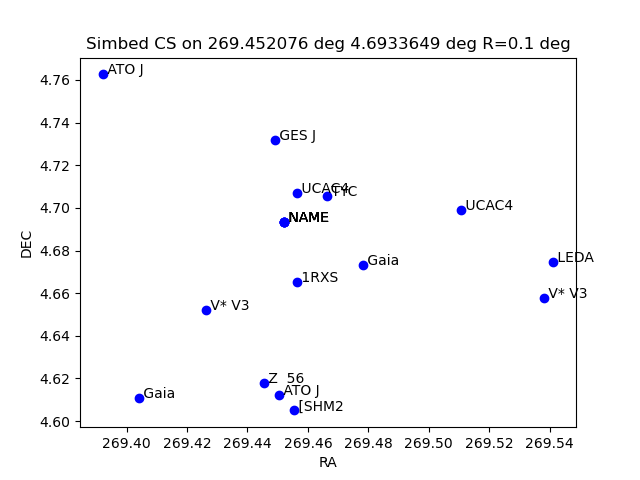

In [128]:
matplotlib.pyplot.close("all")
scs_srv = SCSService(SERVER)

query_result = scs_srv.search(
    pos=SkyCoord(ra=RA, dec=DEC, frame='icrs'), radius=SR,
    verbosity=VERB,
    RESPONSEFORMAT="mivot", MAXREC=MAXREC)
# The MIVOt viewer generates the model view of the data
m_viewer = MivotViewer(query_result, resolve_ref=True)
# Get the first instance mapped in the MIVOt <TEMPLATES>
#XmlUtils.pretty_print(m_viewer._mapping_block)

dates =[]
ras = []
decs = []
now_ras = []
now_decs = []
mango_label = None

mivot_instance = m_viewer.dm_instance
if mivot_instance.dmtype == "mango:MangoObject":
    mango_properties = mivot_instance.propertyDock

    # iterate over the table rows
    while m_viewer.next_row_view():

        scb = SkyCoordBuilder(mivot_instance.to_dict())
        sky_coord = scb.build_sky_coord()
            
        dates.append(f" {mivot_instance.identifier.value}\n obstime: {sky_coord.obstime} \n {str(sky_coord)}")
        ras.append(sky_coord.ra.deg)
        decs.append(sky_coord.dec.deg)
        
ax = setup_plot()        
scatter = build_scatter(ax, ras, decs, dates, "blue")
add_tooltips(scatter, dates)

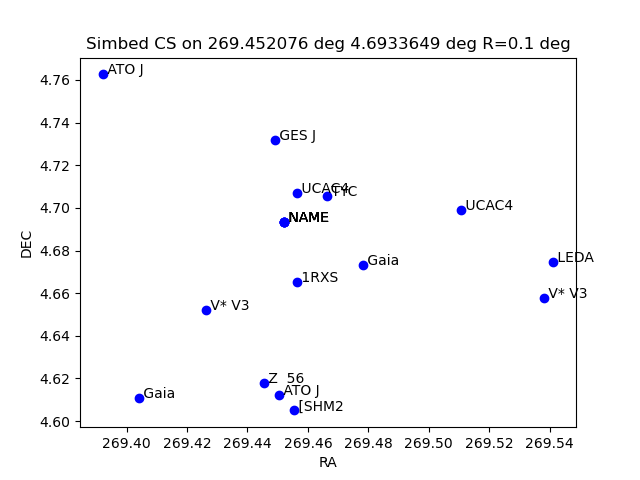

In [129]:
matplotlib.pyplot.close("all")
VERB = 2
query_result = scs_srv.search(
    pos=SkyCoord(ra=RA, dec=DEC, frame='icrs'), radius=SR,
    verbosity=VERB,
    RESPONSEFORMAT="mivot", MAXREC=MAXREC)
# The MIVOt viewer generates the model view of the data
m_viewer = MivotViewer(query_result, resolve_ref=True)
# Get the first instance mapped in the MIVOt <TEMPLATES>
# XmlUtils.pretty_print(m_viewer._mapping_block)

dates =[]
ras = []
decs = []
now_ras = []
now_decs = []
mango_labels = []

mivot_instance = m_viewer.dm_instance
if mivot_instance.dmtype == "mango:MangoObject":
    mango_properties = mivot_instance.propertyDock
    for mango_property in mango_properties:
        if mango_property.dmtype == "mango:label" or mango_property.dmtype == "mango:Label":    
            mango_labels.append(mango_property)
    # iterate over the table rows
    while m_viewer.next_row_view():

        scb = SkyCoordBuilder(mivot_instance.to_dict())
        sky_coord = scb.build_sky_coord()
        lm = ""
        for mango_label in mango_labels:
            lm += mango_label.text.value + " - "
        dates.append(f" {mivot_instance.identifier.value}\n obstime: {sky_coord.obstime}\n {lm} \n {str(sky_coord)}")
        ras.append(sky_coord.ra.deg)
        decs.append(sky_coord.dec.deg)

ax = setup_plot()
scatter = build_scatter(ax, ras, decs, dates, "blue")    
add_tooltips(scatter, dates)        

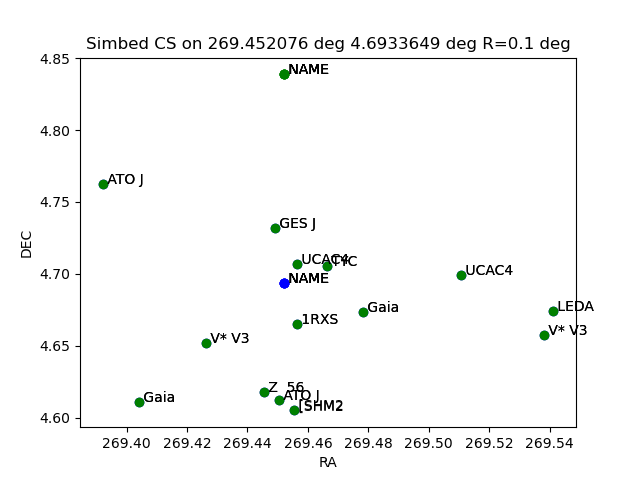

In [133]:
matplotlib.pyplot.close("all")
VERB = 2
query_result = scs_srv.search(
    pos=SkyCoord(ra=RA, dec=DEC, frame='icrs'), radius=SR,
    verbosity=VERB,
    RESPONSEFORMAT="mivot", MAXREC=MAXREC)
# The MIVOt viewer generates the model view of the data
m_viewer = MivotViewer(query_result, resolve_ref=True)
# Get the first instance mapped in the MIVOt <TEMPLATES>
# XmlUtils.pretty_print(m_viewer._mapping_block)

dates =[]
future_dates =[]
ras = []
decs = []
now_ras = []
now_decs = []
mango_labels = []

mivot_instance = m_viewer.dm_instance
if mivot_instance.dmtype == "mango:MangoObject":
    mango_properties = mivot_instance.propertyDock
    for mango_property in mango_properties:
        if mango_property.dmtype == "mango:label" or mango_property.dmtype == "mango:Label":    
            mango_labels.append(mango_property)
    # iterate over the table rows
    while m_viewer.next_row_view():

        scb = SkyCoordBuilder(mivot_instance.to_dict())
        sky_coord = scb.build_sky_coord()
        lm = ""
        for mango_label in mango_labels:
            lm += mango_label.text.value + " - "
        dates.append(f" {mivot_instance.identifier.value}\n obstime: {sky_coord.obstime} \n {lm} \n {str(sky_coord)}")
        ras.append(sky_coord.ra.deg)
        decs.append(sky_coord.dec.deg)
        try:
            sky_coord_future = sky_coord.apply_space_motion(new_obstime=Time('J2050.5'))
            now_ras.append(sky_coord_future.ra.deg)
            now_decs.append(sky_coord_future.dec.deg)
            future_dates.append(f" {mivot_instance.identifier.value}\n "
                                f"obstime: {sky_coord_future.obstime} \n "
                                f"{lm} \n {str(sky_coord_future)}")
        except Exception:
            now_ras.append(sky_coord.ra.deg)
            now_decs.append(sky_coord.dec.deg)
            future_dates.append(f" {mivot_instance.identifier.value}\n epoch: 2025.5 \n {lm} \n {str(sky_coord)}")

ax = setup_plot()

scatter = build_scatter(ax, ras, decs, dates, "blue")
add_tooltips(scatter, dates)

scatter_future = build_scatter(ax, now_ras, now_decs, dates, "green")
add_tooltips(scatter_future, future_dates)        